In [2]:
import sys
sys.version

'3.5.2 (v3.5.2:4def2a2901a5, Jun 26 2016, 10:47:25) \n[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]'

In [3]:
from sklearn.datasets import load_digits

In [4]:
digits = load_digits()
print(digits.data.shape)

(1797, 64)


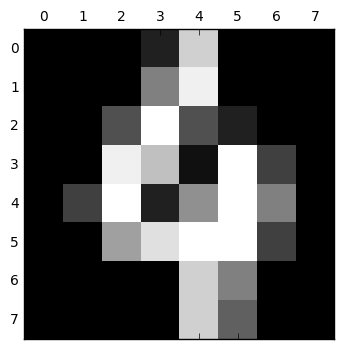

target: 4
target: 4


In [5]:
import matplotlib.pyplot as plt 
index = 100

plt.gray() 
plt.matshow(digits.images[index]) 
plt.show() 
print ("target:", digits.target[index])
print ("target:", digits.target_names[digits.target[index]])


In [6]:
from sklearn.model_selection import train_test_split
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(digits.images, [0 if x%2==0 else 1 for x in digits.target], test_size=0.33, random_state=42)

In [7]:
print (X_train_orig.shape)

(1203, 8, 8)


In this case has "X_train_orig" shape like (1203, 8, 8) which means that there are 1203 examples of 8x8 images. I need to apply reshape because I would like to use logistic regression:
- $A = \sigma(w^T X + b)$
- error funcion $$ \mathcal{L}(a, y) =  - y  \log(a) - (1-y)  \log(1-a)$$
- cost function $$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$ which can be rewritten to $$J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$$
- $\sigma$ is sigmoid function $$sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$$

Because of $w^T X$ I need  $w$ to have shape $(8*8,1)$ and therefore $X$ has to be shape $(8*8,-1)$

The error funcion $ \mathcal{L}(a, y) =  - y  \log(a) - (1-y)  \log(1-a)$ is chosen because when:
- true label is 0 then $ \mathcal{L}(a, y) = - (1-y)  \log(1-a)$ and to minimaze this we need $(1-a)$ to be large therefore $a$ to be small (close to 0)
- true label is 1 then $ \mathcal{L}(a, y) = - y  \log(a)$ and to minimaze this we need $(a)$ to be large therefore $a$ to be large (close to 1)

In [8]:
import numpy as np

X_train = X_train_orig.reshape(-1 , X_train_orig.shape[1] * X_train_orig.shape[2]).T
X_test = X_test_orig.reshape(-1, X_test_orig.shape[1] * X_test_orig.shape[2]).T
y_train = np.array(y_train_orig).reshape(1,-1)
y_test = np.array(y_test_orig).reshape(1,-1)

print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(64, 1203)
(64, 594)
(1, 1203)
(1, 594)


In [9]:
digits.images[0]

array([[  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.],
       [  0.,   0.,  13.,  15.,  10.,  15.,   5.,   0.],
       [  0.,   3.,  15.,   2.,   0.,  11.,   8.,   0.],
       [  0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.],
       [  0.,   5.,   8.,   0.,   0.,   9.,   8.,   0.],
       [  0.,   4.,  11.,   0.,   1.,  12.,   7.,   0.],
       [  0.,   2.,  14.,   5.,  10.,  12.,   0.,   0.],
       [  0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.]])

In [10]:
X_train[:,0]

array([  0.,   0.,   0.,   1.,  12.,   7.,   0.,   0.,   0.,   0.,   0.,
         9.,  16.,  16.,   1.,   0.,   0.,   1.,   7.,  15.,  16.,  14.,
         0.,   0.,   0.,   4.,  16.,  16.,  16.,  16.,   0.,   0.,   0.,
         0.,   0.,   3.,  16.,  16.,   0.,   0.,   0.,   0.,   0.,   2.,
        16.,  16.,   3.,   0.,   0.,   0.,   0.,   6.,  16.,  16.,   0.,
         0.,   0.,   0.,   0.,   3.,  15.,  13.,   0.,   0.])

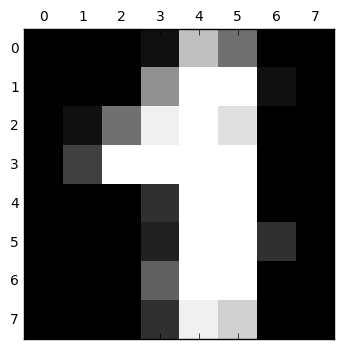

In [11]:
plt.gray() 
plt.matshow(X_train[:,0].reshape(8,8)) 
plt.show() 

<img src="img/logistic_regression_graph.png"/>

To calculated derivative $dw$ and $db$ we need to use calsulus:
$$ \frac{\partial L}{\partial w^{(i)}} = x^{(i)} * \frac{\partial L}{\partial z^{(i)}} = x^{(i)} * \frac{\partial L}{\partial a^{(i)}} * \frac{\partial a^{(i)}}{\partial z^{(i)}}$$
- because of derivative of composite function

$$ \frac{\partial L}{\partial z^{(i)}} = \frac{\partial L}{\partial a^{(i)}} * \frac{\partial a^{(i)}}{\partial z^{(i)}} = (- \frac{y^{(i)}}{a^{(i)}} + \frac{(1-y^{(i)})}{(1-a^{(i)})}) * (a^{(i)} * (1 - a^{(i)})) = a^{(i)} - y^{(i)}$$


We can vectorize error function and transform into:
$$ \frac{\partial L}{\partial z} = (A-Y)$$

and for cost function we get:
$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

In [14]:
# w = np.zeros((X_train_orig.shape[1] * X_train_orig.shape[2], 1))
w = np.random.randn(X_train_orig.shape[1] * X_train_orig.shape[2], 1)
b = 0.0

In [15]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

def sigmoid_derivate(z):
    return sigmoid(z) * (1 - sigmoid(z))

def propagate(w, b, X, Y):
    m = X.shape[1] # num of examples
    
    # math is shown above
    A = sigmoid(np.dot(w.T, X) + b)
    cost = - 1.0/m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))
    
    # how big mistake is in the certain part of w with respect to Cost function
    dw = 1/m * np.dot(X, (A - Y).T)
    db = 1/m * np.sum(A - Y)
    
    results = {"dw": dw,
               "db": db,
               "cost": cost}
    
    return results

def optimize(w, b, X, Y, learning_rate, num_iteration):
    # good for logging and plotting graph
    costs = []
    
    for i in range(num_iteration):
        propagation = propagate(w, b, X, Y)
        costs.append(propagation["cost"])
        
        w = w - learning_rate * propagation["dw"]
        b = b - learning_rate * propagation["db"]
    
    results = {"w": w,
               "b": b,
               "costs": costs}
    
    return results

def predict(w, b, X, treshold = 0.5):
    A = sigmoid(np.dot(w.T, X) + b)
    return np.array([1 if x >= treshold else 0 for x in A[0]]).reshape(1,-1)

In [39]:
class LogisticRegression:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.w = np.zeros((X_train_orig.shape[1] * X_train_orig.shape[2], 1))
        self.b = 0.0
        
    def train(self, learning_rate, num_iteration):
        self.learning_rate = learning_rate
        self.num_iteration = num_iteration
        
        results = optimize(self.w, self.b, self.X_train, self.y_train, learning_rate, num_iteration)
        self.costs = results["costs"]
        self.w = results["w"]
        self.b = results["b"]
    
    def test(self):
        prediction = predict(self.w, self.b, self.X_test)
        return float(100 - np.mean(np.abs(prediction - self.y_test)) * 100)
    
    def predict(self, example):
        return predict(self.w, self.b, example)
    
    def show_cost_curve(self):
        import matplotlib.pyplot as plt 
        plt.plot(self.costs)
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title("Learning rate =" + str(self.learning_rate) + "\nIteration =" + str(self.num_iteration))
        plt.show()

In [40]:
regression = LogisticRegression(X_train, y_train, X_test, y_test)
regression.train(0.001, 1000)
print (regression.test() , "%")

93.26599326599327 %


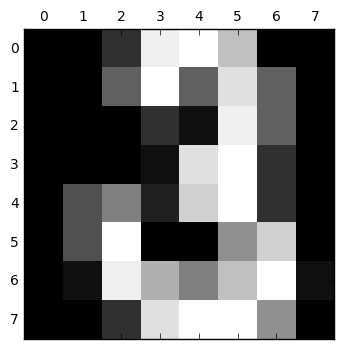

is the number on the picture odd: False


In [41]:
example = X_train[:,10].reshape(8*8,1)
# show image
plt.gray() 
plt.matshow(example.reshape(8,8)) 
plt.show() 
# give prediction
print ("is the number on the picture odd:" , bool(regression.predict(example)))

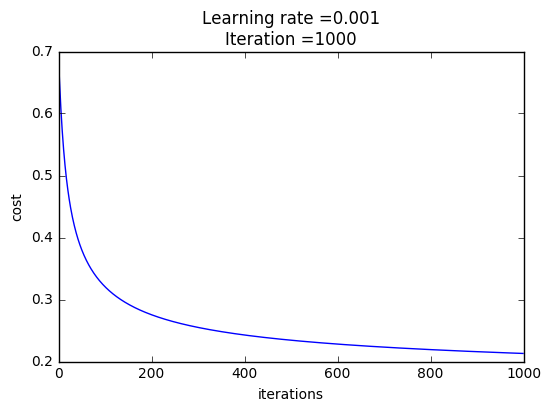

In [42]:
regression.show_cost_curve()

# Resources
- https://www.coursera.org/learn/neural-networks-deep-learning
- http://ronny.rest/blog/post_2017_08_12_logistic_regression_derivative/
- 